# Prompt Binning

## Methodology

The clustering process involves generating dense embeddings using the Jina Embeddings V3 model to capture semantic relationships between prompts, followed by applying K-means clustering with k=30 clusters based on elbow method analysis that showed diminishing returns in WCSS reduction beyond this point. 
This approach was selected over density-based methods (DBSCAN, HDBSCAN) and hierarchical clustering after comparative analysis revealed K-means provided the most balanced cluster distribution with a coefficient of variation of 0.398, indicating reasonably balanced clusters suitable for downstream prompt binning tasks.

# Imports and Setup

---

In [21]:
import pandas as pd
import numpy as np
from os import path
import sys
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
from collections import Counter
import csv
import re

sys.path.append(path.dirname(path.abspath("")))
project_root = path.dirname(path.abspath(""))
print(project_root)

/home/finnf/dev/team-10


# Data Loading and Exploration

---

Load the clean training dataset and explore the unique prompts to understand the scope of clustering work.

In [2]:
csv_file_train = "../data/clean_train.csv"
csv_file_test = "../data/clean_test.csv"

df_train = pd.read_csv(csv_file_train)
df_test = pd.read_csv(csv_file_test)

df_train.head()
df_test.head()

,prompt,essay,evaluation,band_score_old,task_achievement_description,task_achievement_score,coherence_and_cohesion_description,coherence_and_cohesion_score,lexical_resource_description,lexical_resource_score,grammatical_range_and_accuracy_description,grammatical_range_and_accuracy_score,overall_band_score_description,band_score
0,Interview form the basic selection criteria fo...,To agree or disagree with the statement that i...,**Task Achievement (6.5)**\n- The essay effect...,6.5\n\n\n\n\n\r\r\r\r\r\r\r\r\r\r\r\r\r,Task Achievement (6.5)** - The essay effective...,6.5,Coherence and Cohesion (7.0)** - The essay is ...,7.0,Lexical Resource (6.0)** - The essay uses a ra...,6.0,Grammatical Range and Accuracy (6.5)** - The e...,6.5,Overall Band Score: 6.5** - The essay meets th...,6.5
1,The increase in the production of consumer con...,It is true that the rise in consumer productio...,**Task Achievement:**\n- The essay adequately ...,8\n\n\n\n\n\r\r\r\r\r\r\r\r\r\r\r\r\r,Task Achievement:** - The essay adequately add...,8.5,Coherence and Cohesion:** - The essay flows sm...,8.0,Lexical Resource (Vocabulary):** - The essay d...,7.5,Grammatical Range and Accuracy:** - The essay ...,7.0,Overall Band Score:** - Considering the essay'...,8.0
2,The increase in the production of consumer goo...,It is widely argued that the growth of the num...,**Task Achievement:**\n\nThe essay effectively...,8.5\n\n\n\n\n\r\r\r\r\r\r\r\r\r\r\r\r\r,Task Achievement:** The essay effectively addr...,8.5,Coherence and Cohesion:** The essay is well-or...,8.0,Lexical Resource (Vocabulary):** The essay dem...,7.5,Grammatical Range and Accuracy:** The essay ge...,7.0,Overall Band Score:** Considering the synergy ...,8.5
3,The increase in the production of consumer goo...,"In recent years, an increase in the manufactur...",**Task Achievement: 3.5**\n- The essay effecti...,4\n\n\n\n\n\r\r\r\r\r\r\r\r\r\r\r\r\r,Task Achievement: 3.5** - The essay effectivel...,3.5,Coherence and Cohesion: 4** - Transitions betw...,4.0,Lexical Resource (Vocabulary): 3.5** - The ess...,3.5,Grammatical Range and Accuracy: 3.5** - The es...,3.5,Overall Band Score: 4** - The essay demonstrat...,4.0
4,The increase in the production of consumer goo...,The natural environment is harmed as a result ...,### Task Achievement: 7\nThe essay adequately ...,8\n\n\n\n\n\r\r\r\r\r\r\r\r\r\r\r\r\r,Task Achievement: 7 The essay adequately addre...,7.0,Coherence and Cohesion: 6 The essay generally ...,6.0,Lexical Resource: 6 The essay demonstrates a l...,6.0,Grammatical Range and Accuracy: 6 The essay ex...,6.0,Overall Band Score: 7 The essay meets the task...,7.0


In [3]:
len(df_train["prompt"].unique())

2386

In [4]:
df_train["prompt"].sample(5)

2334    Some people think watching television is bad f...
2515    Some people think news has no connection to pe...
6874    In some countries, more and more people are be...
2895    Schools should focus on academic success and p...
4511    Some people think that robots are very importa...
Name: prompt, dtype: object

# Dimensionality Reduction with Sentence Transformer

---

Generate embeddings for all unique prompts using Jina Embeddings V3 to create vector representations suitable for clustering analysis.

In [5]:
# Train

# Extract unique prompts
unique_prompts = df_train["prompt"].unique().tolist()
print(f"{len(unique_prompts)} unique prompts to embed…")

# Compute embeddings using Jina Embeddings V3
model = SentenceTransformer("jinaai/jina-embeddings-v3", trust_remote_code=True)

embeddings = model.encode(
    unique_prompts,
    batch_size=64,
    show_progress_bar=True,
)
X = np.vstack(embeddings)  # shape = (N, embed_dim)

# Test

# Extract unique prompts
unique_prompts_test = df_test["prompt"].unique().tolist()
print(f"{len(unique_prompts_test)} unique prompts to embed…")

embeddings_test = model.encode(
    unique_prompts_test,
    batch_size=64,
    show_progress_bar=True,
)
X_test = np.vstack(embeddings_test)  # shape = (N, embed_dim)

2386 unique prompts to embed…


flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Batches:   0%|          | 0/38 [00:00<?, ?it/s]

332 unique prompts to embed…


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

# Clustering Analysis 

---

Try several methods.

## Elbow Method for Optimal K

Determine the optimal number of clusters by analyzing the within-cluster sum of squares (WCSS) across different k values and calculating percentage decreases.

100%|██████████| 100/100 [06:00<00:00,  3.61s/it]


Percentage decrease in WCSS between consecutive k values:
From k=1 to k=2: 8.32%
From k=2 to k=3: 5.39%
From k=3 to k=4: 4.65%
From k=4 to k=5: 4.44%
From k=5 to k=6: 3.95%
From k=6 to k=7: 4.47%
From k=7 to k=8: 3.81%
From k=8 to k=9: 3.43%
From k=9 to k=10: 2.49%
From k=10 to k=11: 3.27%
From k=11 to k=12: 2.99%
From k=12 to k=13: 1.70%
From k=13 to k=14: 3.60%
From k=14 to k=15: 1.86%
From k=15 to k=16: 2.65%
From k=16 to k=17: 1.55%
From k=17 to k=18: 2.72%
From k=18 to k=19: 2.46%
From k=19 to k=20: 1.74%
From k=20 to k=21: 2.53%
From k=21 to k=22: 2.56%
From k=22 to k=23: 2.50%
From k=23 to k=24: 2.61%
From k=24 to k=25: 1.96%
From k=25 to k=26: 0.24%
From k=26 to k=27: 3.03%
From k=27 to k=28: 2.29%
From k=28 to k=29: 2.91%
From k=29 to k=30: 1.99%
From k=30 to k=31: 0.53%
From k=31 to k=32: 1.16%
From k=32 to k=33: 2.79%
From k=33 to k=34: 2.68%
From k=34 to k=35: 0.34%
From k=35 to k=36: 2.62%
From k=36 to k=37: 0.50%
From k=37 to k=38: 1.98%
From k=38 to k=39: 1.65%
From k=3

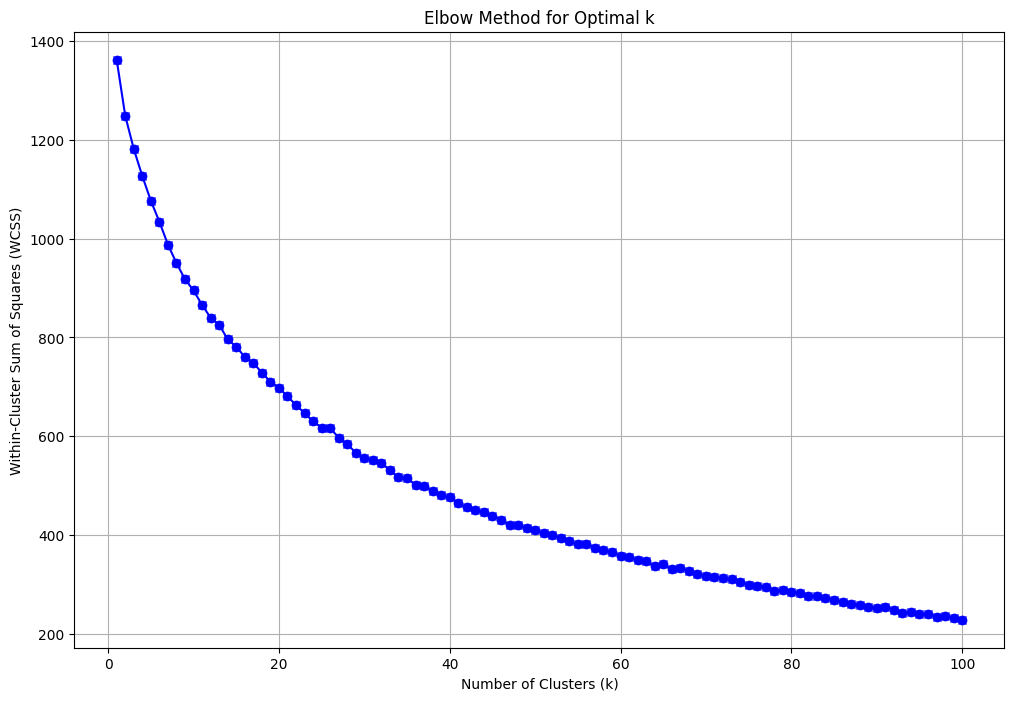

In [6]:
# Calculate WCSS for different numbers of clusters
max_clusters = 100  # Test up to 20 clusters
wcss = []
K = range(1, max_clusters + 1)

for k in tqdm(K):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Create the elbow plot
plt.figure(figsize=(12, 8))
plt.plot(K, wcss, "bx-")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.title("Elbow Method for Optimal k")
plt.grid(True)

# Add markers to make the line more visible
plt.plot(K, wcss, "bo")

# Calculate the percentage decrease in WCSS
wcss_decreases = np.diff(wcss) / wcss[:-1] * 100
print("\nPercentage decrease in WCSS between consecutive k values:")
for k, decrease in enumerate(wcss_decreases, start=1):
    print(f"From k={k} to k={k + 1}: {abs(decrease):.2f}%")

plt.show()

## K-Means Clustering

Apply K-means clustering with the selected optimal number of clusters (k=30) to group similar prompts together.

In [7]:
# Choose reasonable number of clusters
optimal_k = 30
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X)

binned_kmeans = pd.DataFrame({"prompt": unique_prompts, "cluster": cluster_labels})

### Cluster Analysis Function

Define  functions to analyze cluster balance, distribution, and quality metrics including coefficient of variation and Gini coefficient.

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def plot_cluster_distribution(
    cluster_labels, title="Cluster Distribution Analysis", figsize=(15, 10)
):
    """
    Plots comprehensive cluster distribution analysis including balance metrics.

    Parameters:
    -----------
    cluster_labels : array-like
        Array of cluster assignments for each data point
    title : str
        Title for the overall plot
    figsize : tuple
        Figure size (width, height)

    Returns:
    --------
    dict : Dictionary containing balance metrics
    """

    # Convert to pandas Series for easier manipulation
    clusters = pd.Series(cluster_labels)
    cluster_counts = clusters.value_counts().sort_index()

    # Calculate balance metrics
    n_clusters = len(cluster_counts)
    total_points = len(clusters)
    mean_size = cluster_counts.mean()
    std_size = cluster_counts.std()
    cv = std_size / mean_size  # Coefficient of variation

    # Gini coefficient (measure of inequality)
    sorted_counts = np.sort(cluster_counts.values)
    n = len(sorted_counts)
    cumsum = np.cumsum(sorted_counts)
    gini = (n + 1 - 2 * np.sum(cumsum) / cumsum[-1]) / n

    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle(
        f"{title}\nTotal Points: {total_points}, Clusters: {n_clusters}", fontsize=16
    )

    # 1. Bar plot of cluster sizes
    ax1 = axes[0, 0]
    bars = ax1.bar(
        range(len(cluster_counts)),
        cluster_counts.values,
        color="skyblue",
        edgecolor="navy",
        alpha=0.7,
    )
    ax1.axhline(
        y=mean_size,
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Mean: {mean_size:.1f}",
    )
    ax1.axhline(
        y=mean_size + std_size,
        color="orange",
        linestyle=":",
        alpha=0.7,
        label=f"+1 STD: {mean_size + std_size:.1f}",
    )
    ax1.axhline(
        y=mean_size - std_size,
        color="orange",
        linestyle=":",
        alpha=0.7,
        label=f"-1 STD: {mean_size - std_size:.1f}",
    )
    ax1.set_xlabel("Cluster ID")
    ax1.set_ylabel("Number of Points")
    ax1.set_title("Cluster Sizes")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Histogram of cluster sizes
    ax2 = axes[0, 1]
    ax2.hist(
        cluster_counts.values,
        bins=min(20, n_clusters // 2),
        color="lightgreen",
        edgecolor="darkgreen",
        alpha=0.7,
    )
    ax2.axvline(
        x=mean_size,
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Mean: {mean_size:.1f}",
    )
    ax2.set_xlabel("Cluster Size")
    ax2.set_ylabel("Frequency")
    ax2.set_title("Distribution of Cluster Sizes")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. Box plot
    ax3 = axes[1, 0]
    box_plot = ax3.boxplot(cluster_counts.values, patch_artist=True)
    box_plot["boxes"][0].set_facecolor("lightcoral")
    ax3.set_ylabel("Cluster Size")
    ax3.set_title("Cluster Size Distribution (Box Plot)")
    ax3.grid(True, alpha=0.3)

    # Add outlier information
    Q1 = cluster_counts.quantile(0.25)
    Q3 = cluster_counts.quantile(0.75)
    IQR = Q3 - Q1
    outliers = cluster_counts[
        (cluster_counts < Q1 - 1.5 * IQR) | (cluster_counts > Q3 + 1.5 * IQR)
    ]
    if len(outliers) > 0:
        ax3.text(
            0.02,
            0.98,
            f"Outliers: {len(outliers)}",
            transform=ax3.transAxes,
            verticalalignment="top",
            bbox=dict(boxstyle="round", facecolor="yellow", alpha=0.5),
        )

    # 4. Cumulative distribution
    ax4 = axes[1, 1]
    sorted_sizes = np.sort(cluster_counts.values)
    cumulative_pct = np.arange(1, len(sorted_sizes) + 1) / len(sorted_sizes) * 100
    ax4.plot(sorted_sizes, cumulative_pct, marker="o", markersize=4, color="purple")
    ax4.set_xlabel("Cluster Size")
    ax4.set_ylabel("Cumulative Percentage")
    ax4.set_title("Cumulative Distribution of Cluster Sizes")
    ax4.grid(True, alpha=0.3)

    # Add percentile lines
    for pct in [25, 50, 75]:
        size_at_pct = np.percentile(cluster_counts.values, pct)
        ax4.axvline(x=size_at_pct, color="red", linestyle=":", alpha=0.7)
        ax4.text(
            size_at_pct,
            pct,
            f"  {pct}th: {size_at_pct:.0f}",
            rotation=90,
            verticalalignment="bottom",
        )

    plt.tight_layout()
    plt.show()

    # Print detailed statistics
    print("=" * 60)
    print("CLUSTER BALANCE ANALYSIS")
    print("=" * 60)
    print(f"Number of clusters: {n_clusters}")
    print(f"Total data points: {total_points}")
    print(f"Average cluster size: {mean_size:.2f}")
    print(f"Standard deviation: {std_size:.2f}")
    print(f"Coefficient of variation: {cv:.3f}")
    print(f"Gini coefficient: {gini:.3f}")
    print()

    print("CLUSTER SIZE STATISTICS:")
    print(f"Minimum size: {cluster_counts.min()}")
    print(f"Maximum size: {cluster_counts.max()}")
    print(f"Median size: {cluster_counts.median():.1f}")
    print(f"25th percentile: {cluster_counts.quantile(0.25):.1f}")
    print(f"75th percentile: {cluster_counts.quantile(0.75):.1f}")
    print()

    # Balance interpretation
    print("BALANCE INTERPRETATION:")
    if cv < 0.3:
        balance_status = "EXCELLENT - Very balanced clusters"
    elif cv < 0.5:
        balance_status = "GOOD - Reasonably balanced clusters"
    elif cv < 0.8:
        balance_status = "MODERATE - Some imbalance present"
    else:
        balance_status = "POOR - Highly imbalanced clusters"

    print(f"Coefficient of Variation ({cv:.3f}): {balance_status}")

    if gini < 0.2:
        gini_status = "Low inequality"
    elif gini < 0.4:
        gini_status = "Moderate inequality"
    else:
        gini_status = "High inequality"

    print(f"Gini Coefficient ({gini:.3f}): {gini_status}")
    print()
    # Return metrics for programmatic use
    metrics = {
        "n_clusters": n_clusters,
        "total_points": total_points,
        "mean_size": mean_size,
        "std_size": std_size,
        "coefficient_of_variation": cv,
        "gini_coefficient": gini,
        "min_size": cluster_counts.min(),
        "max_size": cluster_counts.max(),
        "median_size": cluster_counts.median(),
        "cluster_counts": cluster_counts,
    }

    return metrics

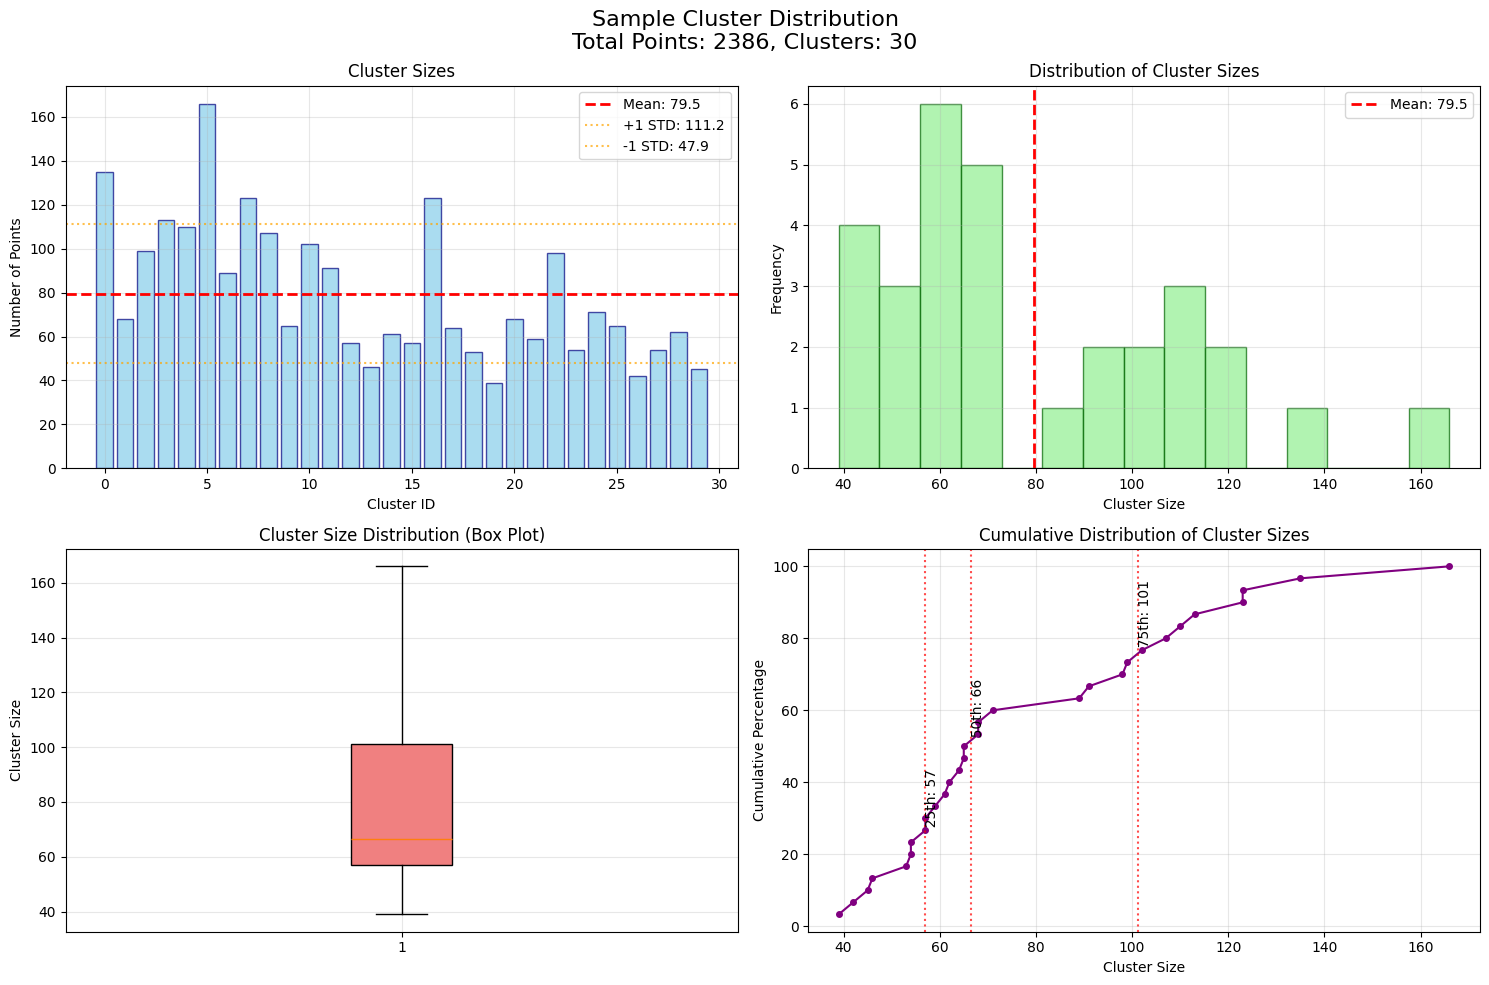

CLUSTER BALANCE ANALYSIS
Number of clusters: 30
Total data points: 2386
Average cluster size: 79.53
Standard deviation: 31.65
Coefficient of variation: 0.398
Gini coefficient: 0.214

CLUSTER SIZE STATISTICS:
Minimum size: 39
Maximum size: 166
Median size: 66.5
25th percentile: 57.0
75th percentile: 101.2

BALANCE INTERPRETATION:
Coefficient of Variation (0.398): GOOD - Reasonably balanced clusters
Gini Coefficient (0.214): Moderate inequality



In [9]:
metrics = plot_cluster_distribution(
    binned_kmeans["cluster"], "Sample Cluster Distribution"
)

## DBSCAN Clustering

Experiment with density-based clustering to identify natural groupings in the prompt embeddings, though results show high imbalance.

In [10]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.33, min_samples=3, metric="cosine")
cluster_labels = dbscan.fit_predict(X)

print(
    f"Number of clusters: {len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)}"
)
print(f"Number of noise points: {list(cluster_labels).count(-1)}")

Number of clusters: 29
Number of noise points: 18


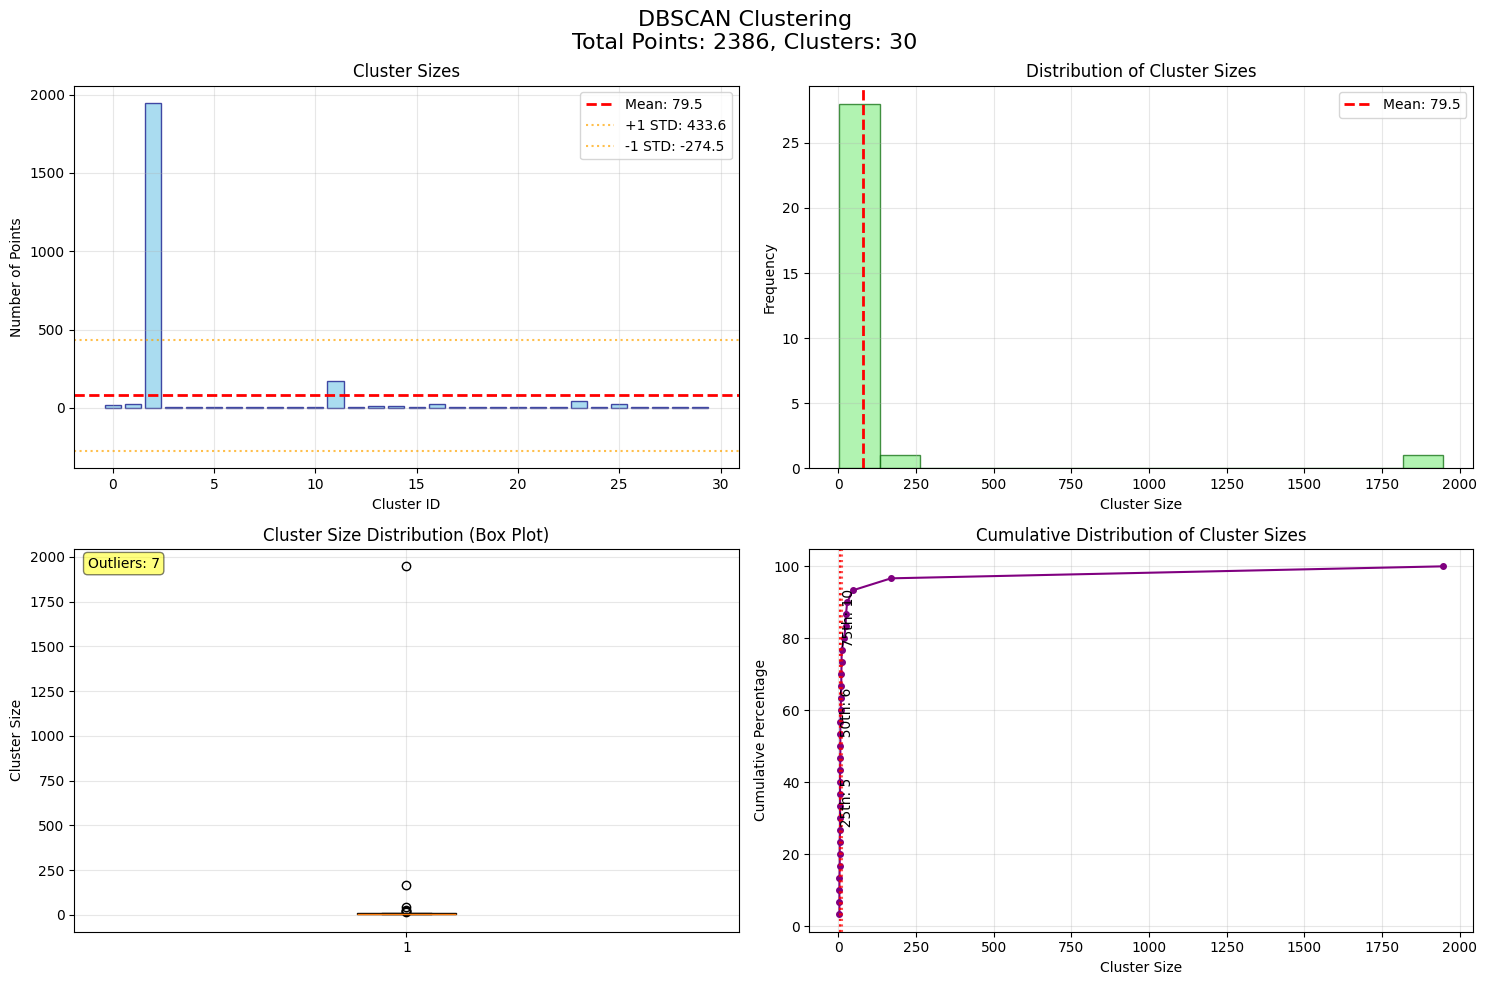

CLUSTER BALANCE ANALYSIS
Number of clusters: 30
Total data points: 2386
Average cluster size: 79.53
Standard deviation: 354.03
Coefficient of variation: 4.451
Gini coefficient: 0.891

CLUSTER SIZE STATISTICS:
Minimum size: 3
Maximum size: 1947
Median size: 6.0
25th percentile: 5.0
75th percentile: 10.0

BALANCE INTERPRETATION:
Coefficient of Variation (4.451): POOR - Highly imbalanced clusters
Gini Coefficient (0.891): High inequality



In [11]:
metrics = plot_cluster_distribution(cluster_labels, "DBSCAN Clustering")

## HDBSCAN Clustering

Test hierarchical density-based clustering as an alternative approach, revealing fewer but still imbalanced clusters.

In [12]:
from sklearn.cluster import HDBSCAN

clusterer = HDBSCAN(
    min_cluster_size=50,
    min_samples=20,
    metric="cosine",
    cluster_selection_method="eom",
    cluster_selection_epsilon=0.25,
)
cluster_labels = clusterer.fit_predict(X)

print(
    f"Number of clusters: {len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)}"
)
print(f"Number of noise points: {list(cluster_labels).count(-1)}")

Number of clusters: 12
Number of noise points: 979


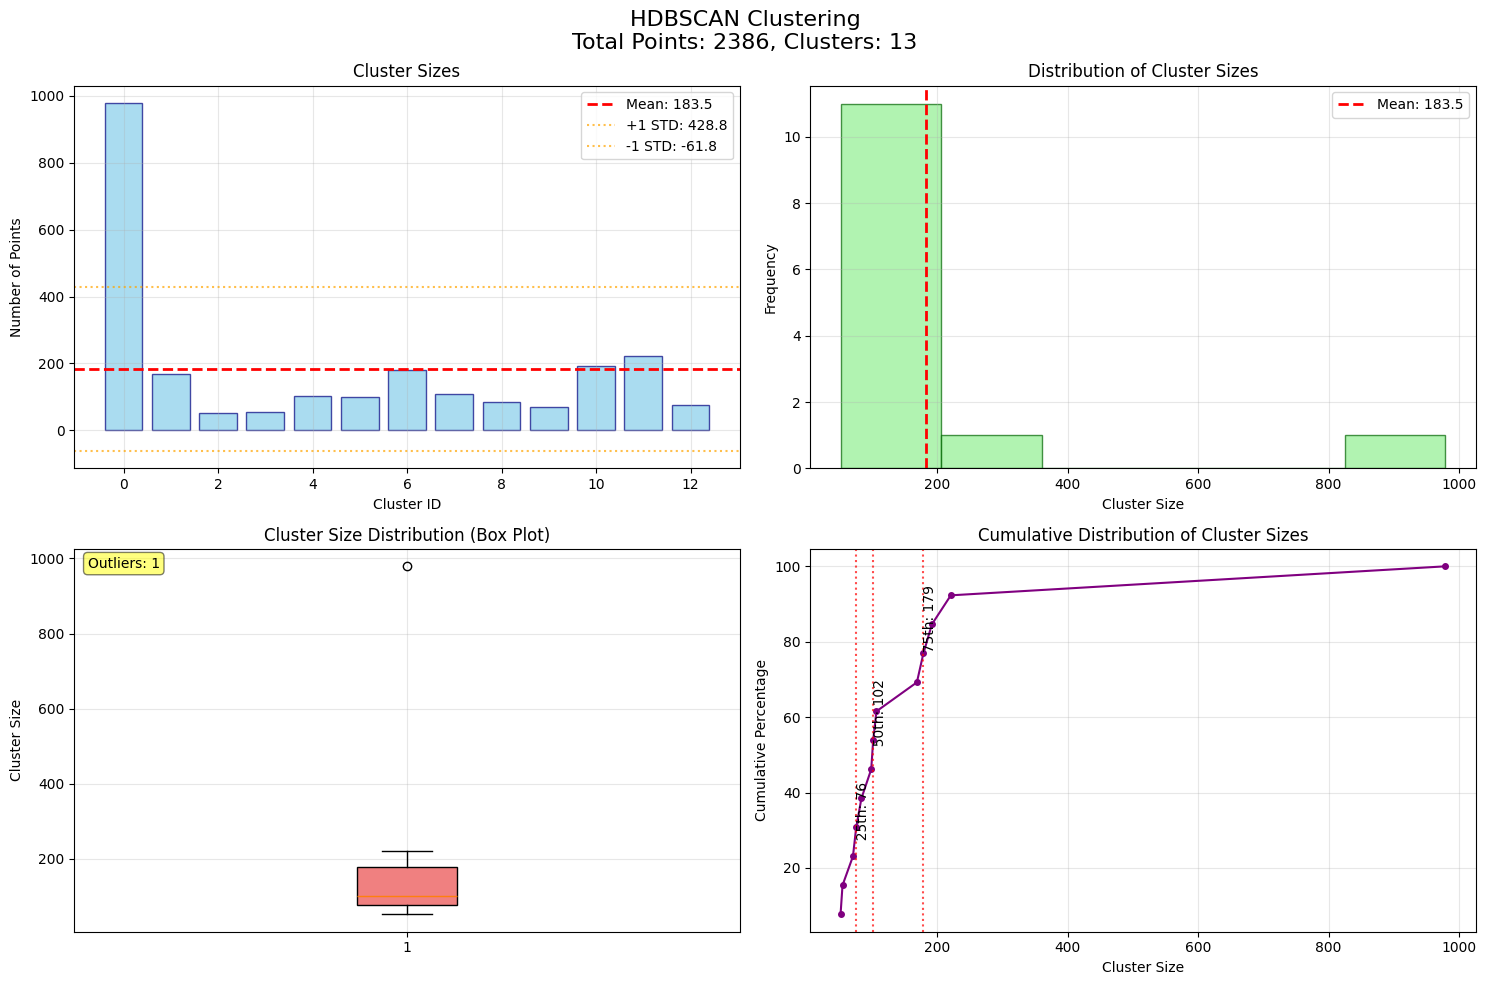

CLUSTER BALANCE ANALYSIS
Number of clusters: 13
Total data points: 2386
Average cluster size: 183.54
Standard deviation: 245.30
Coefficient of variation: 1.337
Gini coefficient: 0.475

CLUSTER SIZE STATISTICS:
Minimum size: 52
Maximum size: 979
Median size: 102.0
25th percentile: 76.0
75th percentile: 179.0

BALANCE INTERPRETATION:
Coefficient of Variation (1.337): POOR - Highly imbalanced clusters
Gini Coefficient (0.475): High inequality



In [13]:
metrics = plot_cluster_distribution(cluster_labels, "HDBSCAN Clustering")

## Agglomerative Clustering

Apply hierarchical clustering using Ward linkage to compare performance with other clustering methods.

In [14]:
from sklearn.cluster import AgglomerativeClustering

agg_clustering = AgglomerativeClustering(n_clusters=30, linkage="ward")

labels = agg_clustering.fit_predict(X)

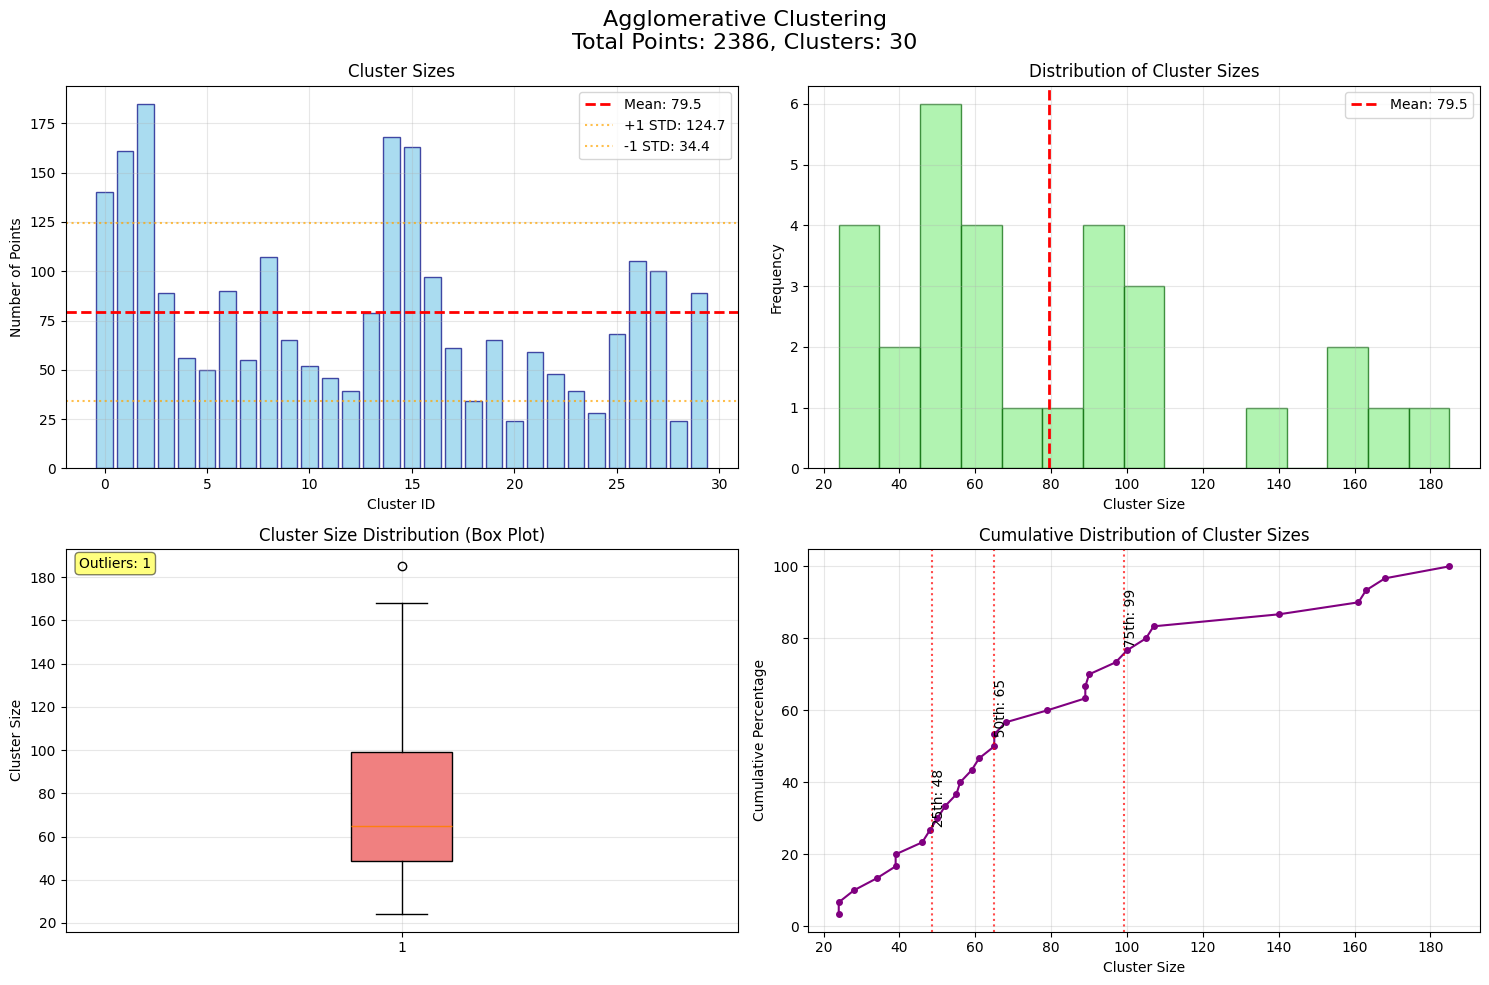

CLUSTER BALANCE ANALYSIS
Number of clusters: 30
Total data points: 2386
Average cluster size: 79.53
Standard deviation: 45.12
Coefficient of variation: 0.567
Gini coefficient: 0.304

CLUSTER SIZE STATISTICS:
Minimum size: 24
Maximum size: 185
Median size: 65.0
25th percentile: 48.5
75th percentile: 99.2

BALANCE INTERPRETATION:
Coefficient of Variation (0.567): MODERATE - Some imbalance present
Gini Coefficient (0.304): Moderate inequality



In [15]:
metrics = plot_cluster_distribution(labels, "Agglomerative Clustering")

## Single Linkage Hierarchical Clustering

Implement custom cosine similarity-based clustering to group prompts with high semantic similarity.

In [16]:
def cosine_similarity_clustering(embeddings, texts, similarity_threshold=0.9):
    """
    Clusters texts based on cosine similarity of their embeddings.

    Args:
        embeddings: numpy array of shape (n_samples, n_features)
        texts: list of original text strings
        similarity_threshold: float between 0 and 1

    Returns:
        pandas DataFrame with original texts and their cluster assignments
    """

    def get_similarity(X, Y):
        return np.dot(X, Y) / (np.linalg.norm(X) * np.linalg.norm(Y))

    # Initialize arrays to store cluster assignments
    n_samples = len(embeddings)
    cluster_labels = np.full(n_samples, -1)
    current_cluster = 0

    # Keep track of unassigned samples
    unassigned = np.arange(n_samples)

    # Continue until all samples are assigned to clusters
    with tqdm(total=n_samples, desc="Clustering") as pbar:
        while len(unassigned) > 0:
            # Take first unassigned sample as new cluster center
            center_idx = unassigned[0]
            center_embedding = embeddings[center_idx]

            # Find all samples similar enough to the center
            similarities = np.array(
                [get_similarity(center_embedding, embeddings[i]) for i in unassigned]
            )
            cluster_members = unassigned[similarities >= similarity_threshold]

            # Assign cluster label to all members
            cluster_labels[cluster_members] = current_cluster

            # Update unassigned samples
            unassigned = np.setdiff1d(unassigned, cluster_members)
            current_cluster += 1

            # Update progress bar
            pbar.update(len(cluster_members))

    # Create DataFrame with results
    results = pd.DataFrame({"prompt": texts, "cluster": cluster_labels})

    # Print clustering statistics
    print("\nClustering Results:")
    print(f"Number of clusters: {current_cluster}")
    cluster_sizes = results["cluster"].value_counts()
    print("\nCluster size distribution:")
    print(f"Mean size: {cluster_sizes.mean():.1f}")
    print(f"Min size: {cluster_sizes.min()}")
    print(f"Max size: {cluster_sizes.max()}")
    print("\nTop 5 largest clusters:")
    print(cluster_sizes.head())

    return results


binned = cosine_similarity_clustering(X, unique_prompts, similarity_threshold=0.8)

Clustering: 100%|██████████| 2386/2386 [00:00<00:00, 2952.15it/s]


Clustering Results:
Number of clusters: 227

Cluster size distribution:
Mean size: 10.5
Min size: 1
Max size: 163

Top 5 largest clusters:
cluster
187    163
113    104
33      99
160     99
53      98
Name: count, dtype: int64


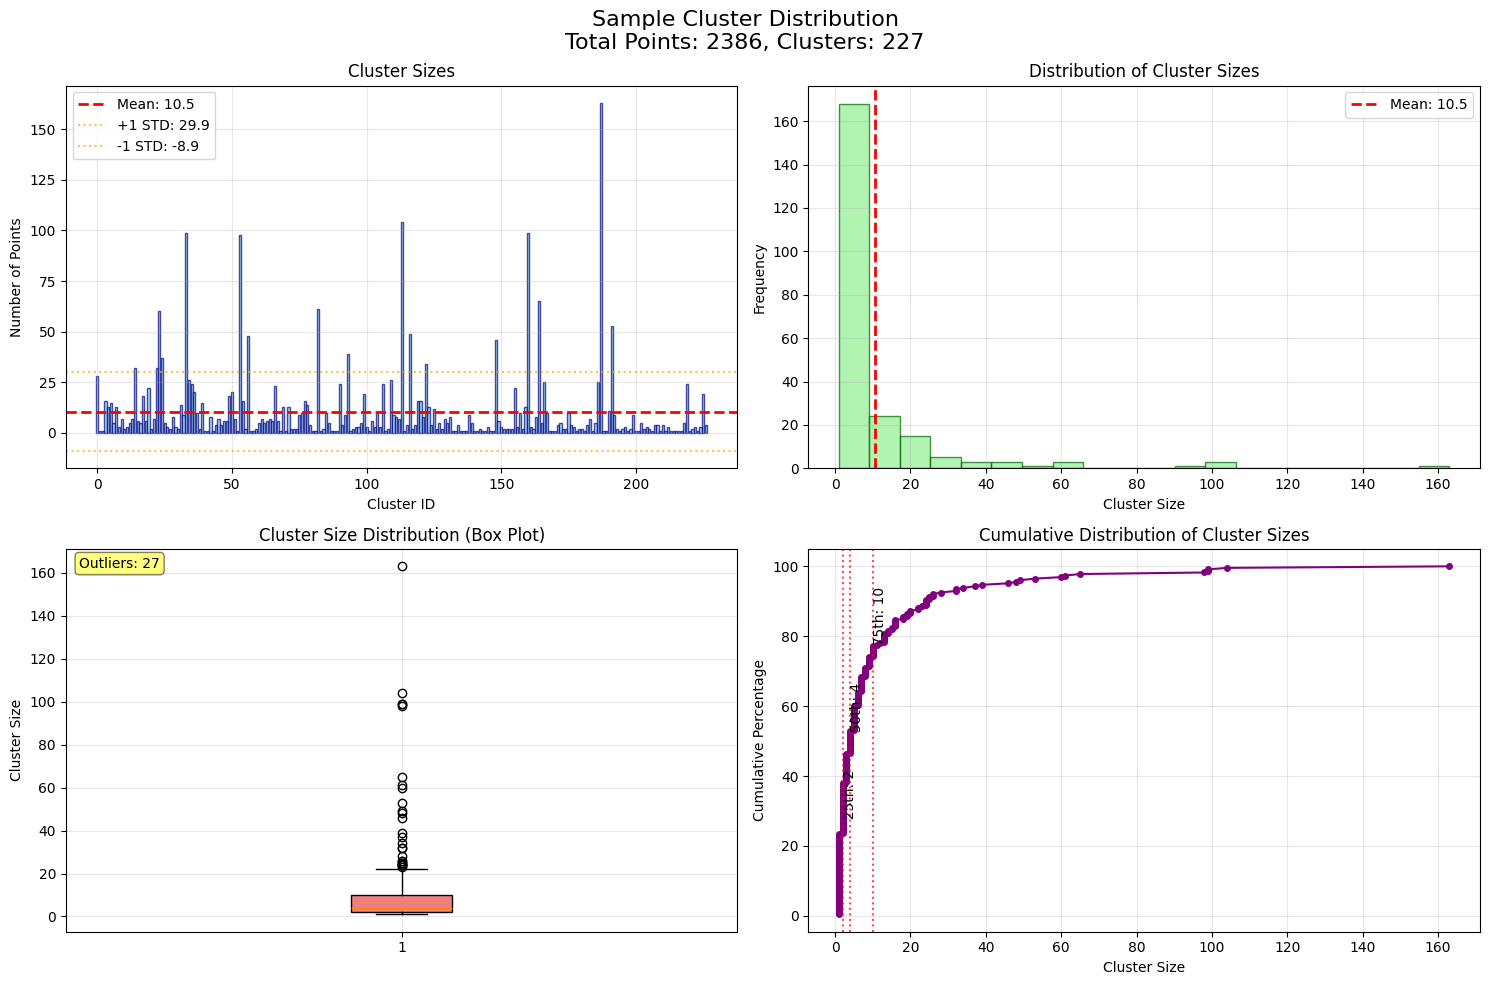

CLUSTER BALANCE ANALYSIS
Number of clusters: 227
Total data points: 2386
Average cluster size: 10.51
Standard deviation: 19.39
Coefficient of variation: 1.845
Gini coefficient: 0.660

CLUSTER SIZE STATISTICS:
Minimum size: 1
Maximum size: 163
Median size: 4.0
25th percentile: 2.0
75th percentile: 10.0

BALANCE INTERPRETATION:
Coefficient of Variation (1.845): POOR - Highly imbalanced clusters
Gini Coefficient (0.660): High inequality



In [17]:
metrics = plot_cluster_distribution(binned["cluster"], "Sample Cluster Distribution")

# K-Means Selected as Best Method

---

Conclude that K-means provides the most balanced clustering results with reasonable cluster sizes and good distribution metrics.

In [18]:
# Train
optimal_k = 30
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X)

binned_kmeans = pd.DataFrame({"prompt": unique_prompts, "cluster": cluster_labels})

# Test
cluster_labels_test = kmeans.predict(X_test)

binned_kmeans_test = pd.DataFrame({"prompt": unique_prompts_test, "cluster": cluster_labels_test})

## Cluster Visualization and Analysis

### Word Frequency Analysis

Analyze the most frequent words in each cluster to understand thematic groupings and remove common words that appear across multiple clusters.

In [19]:
def plot_cluster_word_distributions(
    df,
    text_column="prompt",
    cluster_column="cluster",
    top_n_words=10,
    top_n_clusters=6,
    figsize=(16, 12),
    remove_common_words=True,
):
    """
    Plot word frequency distributions for top clusters.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing text and cluster assignments
    text_column : str
        Name of column containing text data
    cluster_column : str
        Name of column containing cluster assignments
    top_n_words : int
        Number of top words to show per cluster
    top_n_clusters : int
        Number of clusters to analyze (largest clusters)
    figsize : tuple
        Figure size (width, height)
    remove_common_words : bool
        Whether to remove very common words across all clusters

    Returns:
    --------
    dict : Dictionary containing word frequencies for each cluster
    """

    def simple_tokenize(text):
        """Simple tokenization without NLTK"""
        if pd.isna(text):
            return []

        # Convert to lowercase and clean
        text = text.lower()
        # Remove punctuation and numbers, keep only letters and spaces
        text = re.sub(r"[^a-zA-Z\s]", " ", text)
        # Split into words
        words = text.split()

        # Basic stopwords list
        stopwords = nltk.corpus.stopwords.words("english")

        # Filter words: remove stopwords and short words
        words = [word for word in words if word not in stopwords and len(word) > 2]

        return words

    # Get cluster sizes and select top clusters
    cluster_sizes = df[cluster_column].value_counts()
    top_clusters = cluster_sizes.head(top_n_clusters).index.tolist()

    print(f"Analyzing top {len(top_clusters)} clusters by size:")
    for i, cluster_id in enumerate(top_clusters):
        size = cluster_sizes[cluster_id]
        print(f"  {i + 1}. Cluster {cluster_id}: {size} documents")

    # Calculate word frequencies for each cluster
    cluster_word_freqs = {}
    all_words = Counter()

    for cluster_id in top_clusters:
        cluster_texts = df[df[cluster_column] == cluster_id][text_column].tolist()

        # Combine all text in cluster and preprocess
        all_words_in_cluster = []
        for text in cluster_texts:
            words = simple_tokenize(text)
            all_words_in_cluster.extend(words)
            all_words.update(words)  # Track global word frequencies

        # Count word frequencies in this cluster
        word_freq = Counter(all_words_in_cluster)
        cluster_word_freqs[cluster_id] = word_freq

    # Optionally remove very common words across all clusters
    very_common_words = set()
    if remove_common_words:
        # Find words that appear in most clusters (might be too general)
        word_cluster_count = {}
        for cluster_id, word_freq in cluster_word_freqs.items():
            for word in word_freq.keys():
                word_cluster_count[word] = word_cluster_count.get(word, 0) + 1

        # Remove words that appear in more than 70% of clusters
        common_threshold = len(top_clusters) * 0.7
        very_common_words = {
            word
            for word, count in word_cluster_count.items()
            if count > common_threshold
        }

        if very_common_words:
            print(
                f"\nRemoving {len(very_common_words)} very common words: {list(very_common_words)[:10]}..."
            )

    # Create subplots
    n_cols = 2
    n_rows = (len(top_clusters) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    fig.suptitle(f"Top {top_n_words} Words in Each Cluster", fontsize=16, y=0.98)

    # Flatten axes array for easier indexing
    if n_rows == 1:
        axes = [axes] if n_cols == 1 else axes
    else:
        axes = axes.flatten()

    # Color palette
    colors = plt.cm.Set3(np.linspace(0, 1, len(top_clusters)))

    # Plot each cluster
    for i, cluster_id in enumerate(top_clusters):
        word_freq = cluster_word_freqs[cluster_id]

        # Remove very common words if specified
        if remove_common_words:
            filtered_freq = {
                word: count
                for word, count in word_freq.items()
                if word not in very_common_words
            }
            word_freq = Counter(filtered_freq)  # Convert back to Counter

        # Get top words
        top_words = word_freq.most_common(top_n_words)

        if not top_words:  # Skip if no words left after filtering
            axes[i].text(
                0.5,
                0.5,
                "No distinctive words",
                ha="center",
                va="center",
                transform=axes[i].transAxes,
            )
            axes[i].set_title(
                f"Cluster {cluster_id} ({cluster_sizes[cluster_id]} docs)"
            )
            continue

        words, counts = zip(*top_words)

        # Create bar plot
        bars = axes[i].bar(
            range(len(words)),
            counts,
            color=colors[i],
            alpha=0.8,
            edgecolor="black",
            linewidth=0.5,
        )

        # Customize plot
        axes[i].set_title(
            f"Cluster {cluster_id} ({cluster_sizes[cluster_id]} docs)",
            fontsize=12,
            fontweight="bold",
        )
        axes[i].set_xlabel("Words", fontsize=10)
        axes[i].set_ylabel("Frequency", fontsize=10)
        axes[i].set_xticks(range(len(words)))
        axes[i].set_xticklabels(words, rotation=45, ha="right", fontsize=9)
        axes[i].grid(True, alpha=0.3, axis="y")

        # Add value labels on bars
        for bar, count in zip(bars, counts):
            height = bar.get_height()
            axes[i].text(
                bar.get_x() + bar.get_width() / 2.0,
                height + max(counts) * 0.01,
                f"{count}",
                ha="center",
                va="bottom",
                fontsize=8,
            )

    # Hide empty subplots
    for i in range(len(top_clusters), len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.show()

    # Print detailed word analysis
    print("\n" + "=" * 80)
    print("DETAILED WORD ANALYSIS BY CLUSTER")
    print("=" * 80)

    for cluster_id in top_clusters:
        word_freq = cluster_word_freqs[cluster_id]
        if remove_common_words:
            filtered_freq = {
                word: count
                for word, count in word_freq.items()
                if word not in very_common_words
            }
            word_freq = Counter(filtered_freq)

        top_words = word_freq.most_common(top_n_words)
        total_words = sum(word_freq.values())
        unique_words = len(word_freq)

        print(f"\nCluster {cluster_id} ({cluster_sizes[cluster_id]} documents):")
        print(f"  Total words: {total_words:,}")
        print(f"  Unique words: {unique_words:,}")
        print(f"  Top {min(len(top_words), top_n_words)} words:")

        for j, (word, count) in enumerate(top_words, 1):
            percentage = (count / total_words) * 100 if total_words > 0 else 0
            print(f"    {j:2d}. {word:<15} {count:4d} ({percentage:4.1f}%)")

    return cluster_word_freqs

Analyzing top 6 clusters by size:
  1. Cluster 5: 166 documents
  2. Cluster 0: 135 documents
  3. Cluster 7: 123 documents
  4. Cluster 16: 123 documents
  5. Cluster 3: 113 documents
  6. Cluster 4: 110 documents

Removing 21 very common words: ['nowadays', 'people', 'least', 'examples', 'knowledge', 'relevant', 'experience', 'include', 'words', 'believe']...


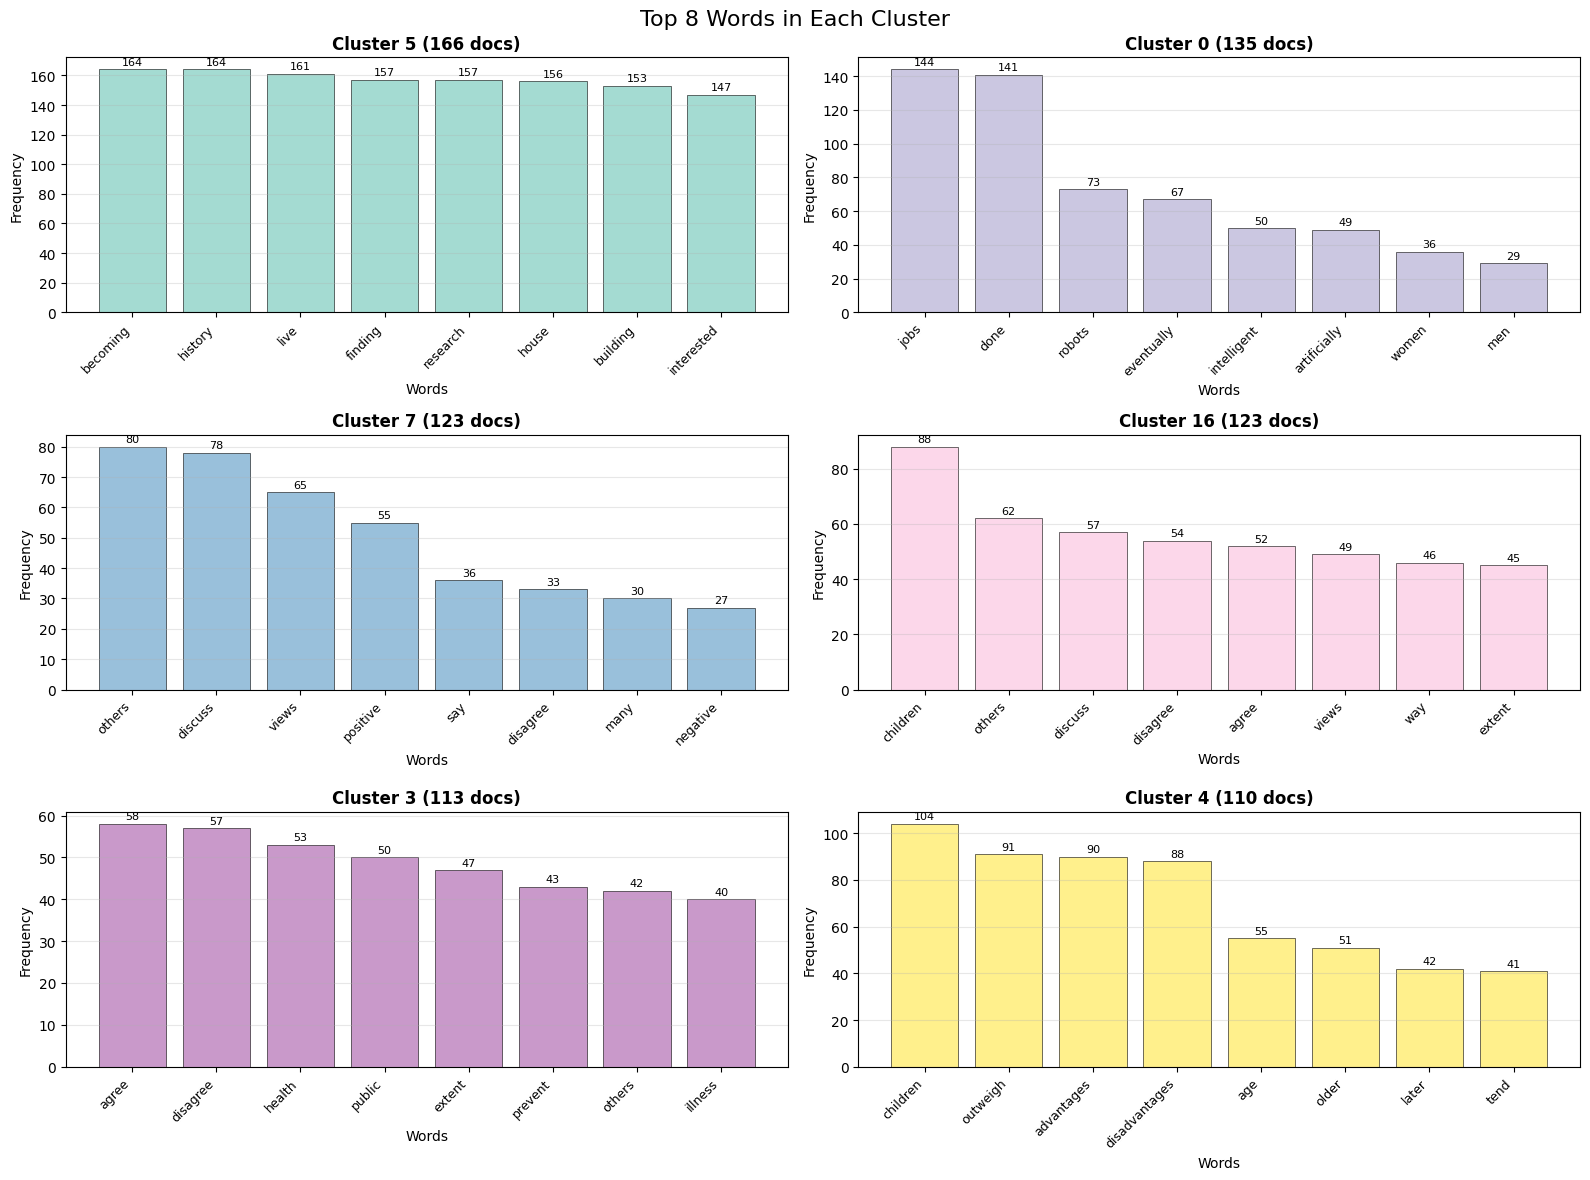


DETAILED WORD ANALYSIS BY CLUSTER

Cluster 5 (166 documents):
  Total words: 1,400
  Unique words: 80
  Top 8 words:
     1. becoming         164 (11.7%)
     2. history          164 (11.7%)
     3. live             161 (11.5%)
     4. finding          157 (11.2%)
     5. research         157 (11.2%)
     6. house            156 (11.1%)
     7. building         153 (10.9%)
     8. interested       147 (10.5%)

Cluster 0 (135 documents):
  Total words: 1,359
  Unique words: 195
  Top 8 words:
     1. jobs             144 (10.6%)
     2. done             141 (10.4%)
     3. robots            73 ( 5.4%)
     4. eventually        67 ( 4.9%)
     5. intelligent       50 ( 3.7%)
     6. artificially      49 ( 3.6%)
     7. women             36 ( 2.6%)
     8. men               29 ( 2.1%)

Cluster 7 (123 documents):
  Total words: 1,636
  Unique words: 276
  Top 8 words:
     1. others            80 ( 4.9%)
     2. discuss           78 ( 4.8%)
     3. views             65 ( 4.0%)
     4. pos

In [22]:
word_freqs = plot_cluster_word_distributions(
    binned_kmeans,
    text_column="prompt",
    cluster_column="cluster",
    top_n_words=8,
    top_n_clusters=6,
    remove_common_words=True,
)

### Word Cloud Visualization

Generate word clouds for the top clusters to visually represent the key themes and topics within each prompt group.

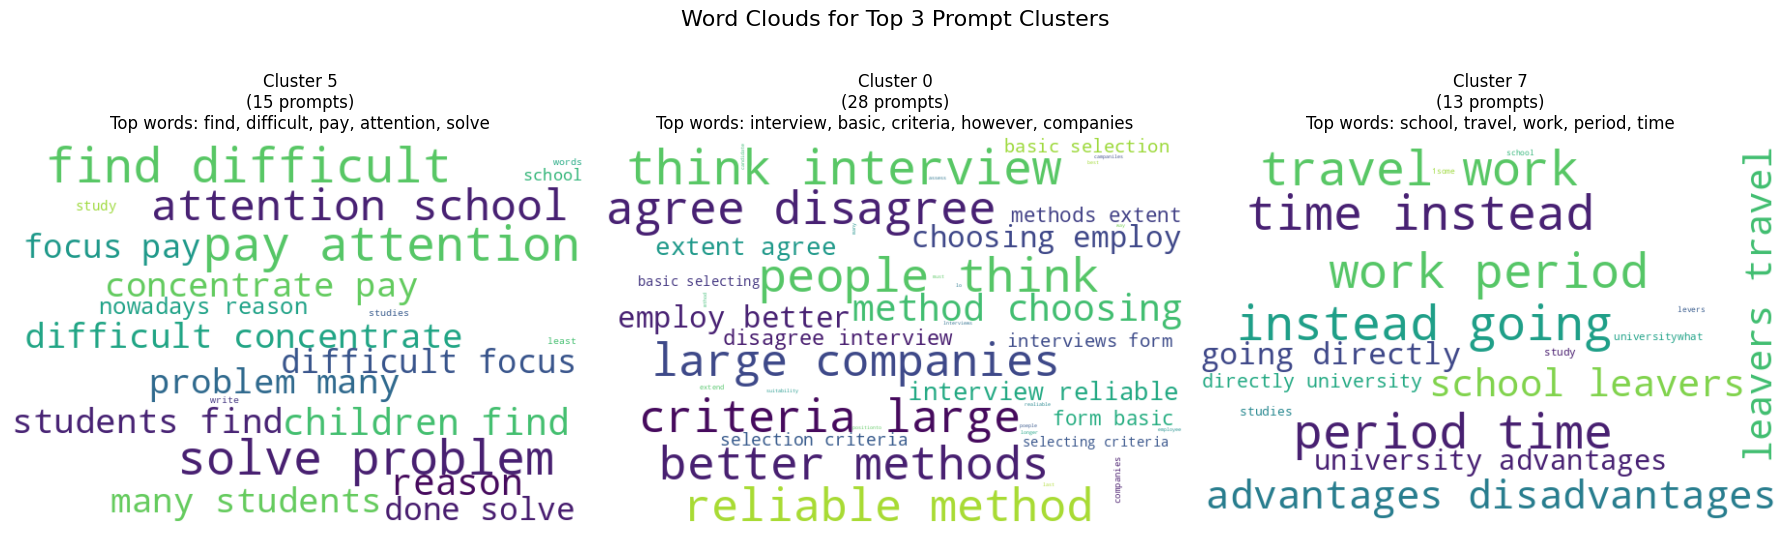


--- SAMPLE PROMPTS FROM CLUSTER 5 ---
1. Many students find it difficult to focus or pay attention at school nowadays. What are the reason for this? What can be done to solve the problem.
2. Children find it difficult to concentrate on or pay attention to school. What are the reasons? How can we solve this problem?
3. Children find it difficult to pay attention or concentrate on school study what are the reasons? How can we solve this problem?
--- END OF CLUSTER 5 SAMPLES ---

--- SAMPLE PROMPTS FROM CLUSTER 0 ---
1. lnterviews form the basic selecting criteria for most large companies. However, some people think that interview is not of reliable method of choosing...
2. Interviews form the basic selection criteria for most large companies. However some people think that interview is not a reliable method of choosing w...
3. Interview forms are the basic selection criteria for the most large companies. However, some people think that interview is not a reliable method of c...
--- END 

In [23]:
from wordcloud import WordCloud
import string

# Download NLTK resources if needed
nltk.download("stopwords", quiet=True)
nltk.download("punkt", quiet=True)

# 1. Choose 3 clusters to visualize (you can pick any 3 clusters with sufficient data)
# Let's find the clusters with the most prompts
cluster_counts = binned_kmeans["cluster"].value_counts()
top_clusters = cluster_counts.nlargest(5).index.tolist()
sample_clusters = top_clusters[:3]  # Take the top 3 most populated clusters


# 2. Define text preprocessing function
def preprocess_text(text):
    # Lowercase and remove punctuation
    text = text.lower()
    text = "".join([char for char in text if char not in string.punctuation])
    # Tokenize
    words = nltk.word_tokenize(text)
    # Remove stopwords and single-character words
    stop_words = set(stopwords.words("english"))
    words = [word for word in words if word not in stop_words and len(word) > 1]
    return " ".join(words)


# 3. Create a figure for the word clouds
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("Word Clouds for Top 3 Prompt Clusters", fontsize=16)

# 4. Generate word cloud for each sample cluster
for i, cluster_id in enumerate(sample_clusters):
    # Get all prompts in this cluster
    cluster_prompts = binned[binned["cluster"] == cluster_id]["prompt"].tolist()

    # Combine and preprocess all text
    combined_text = " ".join(cluster_prompts)
    processed_text = preprocess_text(combined_text)

    # Count most common words for labeling
    word_counts = Counter(processed_text.split())
    top_words = ", ".join([word for word, _ in word_counts.most_common(5)])

    # Generate word cloud
    wordcloud = WordCloud(
        max_font_size=50,
        max_words=100,
        background_color="white",
        width=600,
        height=400,
        random_state=42,
    ).generate(processed_text)

    # Display word cloud
    axes[i].imshow(wordcloud, interpolation="bilinear")
    axes[i].set_title(
        f"Cluster {cluster_id}\n({len(cluster_prompts)} prompts)\nTop words: {top_words}"
    )
    axes[i].axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# 5. Print sample prompts from each cluster for context
for cluster_id in sample_clusters:
    print(f"\n--- SAMPLE PROMPTS FROM CLUSTER {cluster_id} ---")
    sample_prompts = (
        binned[binned["cluster"] == cluster_id]["prompt"]
        .sample(min(3, len(binned[binned["cluster"] == cluster_id])))
        .tolist()
    )
    for j, prompt in enumerate(sample_prompts):
        print(
            f"{j + 1}. {prompt[:150]}..." if len(prompt) > 150 else f"{j + 1}. {prompt}"
        )
    print(f"--- END OF CLUSTER {cluster_id} SAMPLES ---")

## Adding Cluster IDs to Dataset

Merge the cluster assignments back to the original dataset for downstream tasks.

In [24]:
# Add cluster IDs to the original dataframe
df_train = df_train.merge(binned_kmeans[["prompt", "cluster"]], on="prompt", how="left")

# Add cluster IDs to the test dataframe
df_test = df_test.merge(binned_kmeans_test[["prompt", "cluster"]], on="prompt", how="left")

In [25]:
df_train.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9048 entries, 0 to 9047
Data columns (total 15 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   prompt                                      9048 non-null   object 
 1   essay                                       9048 non-null   object 
 2   evaluation                                  9048 non-null   object 
 3   band_score_old                              9048 non-null   object 
 4   task_achievement_description                9048 non-null   object 
 5   task_achievement_score                      9048 non-null   float64
 6   coherence_and_cohesion_description          9048 non-null   object 
 7   coherence_and_cohesion_score                9048 non-null   float64
 8   lexical_resource_description                9048 non-null   object 
 9   lexical_resource_score                      9048 non-null   float64
 10  grammatical_

In [26]:
# Verify the join worked by checking a few rows
df_train[["prompt", "cluster"]].sample(5)

,prompt,cluster
5826,Some people believe that eventually all jobs w...,0
4624,Some people believe that climate has the great...,18
576,Consumers are faced with increasing numbers of...,15
2116,Some people think technology makes life comple...,21
5534,Any country should be able to sell goods to ot...,7


## Data Storage

Save the clustered dataset with prompt cluster IDs for future use.

In [27]:
# Store the df
csv_path_train = "../data/clean_clustered_train.csv"
csv_path_test = "../data/clean_clustered_test.csv"

df_train.to_csv(
    csv_path_train,
    index=False,
    encoding="utf-8",
    quoting=csv.QUOTE_NONNUMERIC,  # Quote all non-numeric fields
    escapechar="\\",
    doublequote=True,
)
df_test.to_csv(
    csv_path_test,
    index=False,
    encoding="utf-8",
    quoting=csv.QUOTE_NONNUMERIC,  # Quote all non-numeric fields
    escapechar="\\",
    doublequote=True,
)

### [`Click here to go back to the Homepage`](../Homepage.md)